## Silverbox

Silverbox refers to one of the nonlinear system identification benchmarks on http://nonlinearbenchmark.org/#Silverbox. 
It is a simulation of a [Duffing oscillator](https://en.wikipedia.org/wiki/Duffing_equation), ocurring for instance in nonlinear spring pendulums.

State-space model description of the system:

$$\begin{align}
m \frac{d^2 x(t)}{dt^2} + v \frac{d x(t)}{dt} + a x(t) + b x^3(t) =&\ u(t) + w(t) \\
y(t) =&\ x(t) + e(t)
\end{align}$$

where
$$\begin{align}
m     =&\ \text{mass} \\
v     =&\ \text{viscous damping} \\
a     =&\ \text{linear stiffness} \\
b     =&\ \text{nonlinear stiffness} \\
y(t)    =&\ \text{observation (displacement)} \\
x(t)    =&\ \text{state (displacement)} \\
u(t)    =&\ \text{force} \\
e(t)    =&\ \text{measurement noise} \\
w(t)    =&\ \text{process noise}
\end{align}$$

The process noise is a Wiener process, where the increment is Gaussian distributed:

$$\begin{align}
w(t) =&\ \frac{d B(t)}{dt} \sim \mathcal{N}(0, \tau^{-1}dt)
\end{align}$$

The parameter $\tau$ represents the precision of the process. The same holds for the measurement noise.

### Solution steps

#### 1. Ignore nonlinear stiffness

For now, we ignore the nonlinear stiffness component by setting the parameter $b$ to 0. The state transition thus reduces to:

$$\begin{align}
m x''(t) + v x'(t) + a x(t) = u(t) + w(t) 
\end{align}$$

#### 2. Finite difference method

I'm using an implicit method, for stability reasons.
The backward difference for both derivative terms:

$$\begin{align}
x''(t) \approx&\ \frac{x(t) - 2x(t-h) + x(t-2h)}{h^2} = \frac{x_t - 2x_{t-1} + x_{t-2}}{\Delta t}\\
x'(t) \approx&\ \frac{x(t) - x(t-h)}{h} = \frac{x_t - x_{t-1}}{\Delta t}\\
\end{align}$$

where $h = \Delta t = t - (t-1) = 1$. A discretization of the Wiener process yields:

$$\begin{align}
w(t) = \frac{dB(t)}{dt} \approx \frac{B(t) - B(t-h)}{h} = \frac{B_t - B_{t-1}}{\Delta t} \sim \mathcal{N}(0, \tau^{-1}\Delta t) \, .
\end{align}$$

Let $w_t$ be a sample from $\mathcal{N}(0, \tau^{-1})$. The DE can now be written as the following discrete-time system:

$$\begin{align}
m (x_t - 2x_{t-1} + x_{t-2}) + v (x_t - x_{t-1}) + a x_t =&\ u_t + w_t \\
(m + v + a) x_t + (-2m - v) x_{t-1} + m x_{t-2} =&\ u_t + w_t \\
x_t + \frac{-2m - v}{m + v + a} x_{t-1} + \frac{m}{m + v + a} x_{t-2} =&\ \frac{1}{m + v + a} u_t + \frac{1}{m + v + a} w_t \\
x_t =&\ \frac{2m + v}{m + v + a} x_{t-1} + \frac{-m}{m + v + a} x_{t-2} + \frac{1}{m + v + a} u_t + \frac{1}{m + v + a} w_t \\
\end{align}$$


#### 3. Change to shorthand notation:

I'm introducing some shorthand to clean the equation up a bit:

$$\begin{align}
x_t = \theta_1 x_{t-1} + \theta_2 x_{t-2} + \eta u_t + \eta w_t
\end{align}$$

where 

$$\begin{align} 
\theta_1 =&\ \frac{2m + v}{m + v + a} \\
\theta_2 =&\ \frac{-m}{m + v + a} \\
\eta =&\ \frac{1}{m + v + a}
\end{align}$$

Given three equations and three unknowns, I can recover $m$, $v$ and $a$ from $\theta_1$, $\theta_2$, and $\eta$.

#### 4. Convert to multivariate first-order form

The system now resembles an auto-regressive process:

$$ \underbrace{\begin{bmatrix} x_t \\ x_{t-1} \end{bmatrix}}_{z_t} = \underbrace{\begin{bmatrix} \theta_1 & \theta_2 \\ 1 & 0 \end{bmatrix}}_{A(\theta)} \underbrace{\begin{bmatrix} x_{t-1} \\ x_{t-2} \end{bmatrix}}_{z_{t-1}} + \underbrace{\begin{bmatrix} \eta \\ 0 \end{bmatrix}}_{B(\eta)} u_t + \begin{bmatrix} \eta \\ 0 \end{bmatrix} w_t \, .$$

Note that we need a two-dimensional state prior now (reminiscent of adding an initial condition on the velocity).

#### 5. Convert to Gaussian probability

The state transition maps to:

$$z_t \sim \mathcal{N}(A(\theta) z_{t-1} + B(\eta) u_t, C(\eta, \tau))$$

where $C(\eta, \tau) = \begin{bmatrix} \frac{\tau^{-1}}{m} & 0 \\ 0 & 0 \end{bmatrix}$. The observation likelihood maps to

$$y_t \sim \mathcal{N}(c^{\top} z_t, \sigma^2)$$

where $c = \begin{bmatrix} 1 & 0 \end{bmatrix}$ and $e_t \sim \mathcal{N}(0, \sigma^2)$. I will first study a situation with known measurement noise, i.e., $\sigma$ is fixed.

#### 6. Choose priors

The mass and stiffness are strictly positive parameters, but the viscous damping coefficient can be negative. As such, the $\theta$'s and $\eta$ can be both both positive and negative and modeled by Gaussian priors. Process precision is strictly positive, so we will use a gamma distribution:

$$\begin{align}
\theta \sim&\ \mathcal{N}(m^{0}_\theta, v^{0}_\theta) \\
\eta \sim&\ \mathcal{N}(m^{0}_\eta, v^{0}_\eta) \\
\tau \sim&\ \Gamma(a^{0}_\tau, b^{0}_\tau) 
\end{align}$$

### Data

Let's first have a look at the data.

In [1]:
using Revise
using CSV
using DataFrames

┌ Info: Precompiling Revise [295af30f-e4ad-537b-8983-00126c2a3abe]
└ @ Base loading.jl:1260


In [2]:
using Plots

viz = false

┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1260


false

In [3]:
# Read data from CSV file
df = CSV.read("../data/SNLS80mV.csv", ignoreemptylines=true)
df = select(df, [:V1, :V2])

# Shorthand
input = df[:,1]
output = df[:,2]

# Time horizon
T = size(df, 1);

In [4]:
if viz
    # Plot every n-th time-point to avoid figure size exploding
    n = 10
    p1 = Plots.scatter(1:n:T, output[1:n:T], color="black", label="output", markersize=2, size=(1600,800), xlabel="time (t)", ylabel="response")
    # Plots.savefig(p1, "viz/output_signal.png")
end

In [5]:
if viz
    p2 = Plots.scatter(1:n:T, input[1:n:T], color="blue", label="output", markersize=2, size=(1600,800), xlabel="time (t)", ylabel="control")
    # Plots.savefig(p2, "viz/input_signal.png")
end

## Estimating parameters via Bayesian filtering

Implementation with ForneyLab and AR node. The AR node is locally modified from the package LAR (LAR is in dev mode).

In [6]:
using ForneyLab
using ForneyLab: unsafeMean, unsafeCov, unsafeVar, unsafePrecision
using LAR
using LAR.Node, LAR.Data
using ProgressMeter

┌ Info: Precompiling ForneyLab [9fc3f58a-c2cc-5bff-9419-6a294fefdca9]
└ @ Base loading.jl:1260
┌ Info: Precompiling LAR [c3bc7fac-5998-4d64-8961-b7df36e0e4ce]
└ @ Base loading.jl:1260
  ** incremental compilation may be fatally broken for this module **



In [50]:
# Start graph
graph = FactorGraph()

# Static parameters
@RV θ ~ GaussianMeanPrecision(placeholder(:m_θ, dims=(2,)), placeholder(:w_θ, dims=(2,2)))
@RV η ~ GaussianMeanPrecision(placeholder(:m_η), placeholder(:w_η))
@RV τ ~ Gamma(placeholder(:a_τ), placeholder(:b_τ))

# # Nonlinear function
# g(x) = exp.(x)
# g_inv(x) = log.(x) # Not used in Nonlinear due to DomainError

# # Nonlinear node
# @RV θ ~ Nonlinear{Unscented}(lθ; g=g, dims=(2,))
# @RV η ~ Nonlinear{Unscented}(lη; g=g, dims=(1,))

# Observation selection variable
c = [1, 0]

# Measurement precision
σ = 1e3

# State prior
@RV z_t ~ GaussianMeanPrecision(placeholder(:m_z, dims=(2,)), placeholder(:w_z, dims=(2, 2)), id=:z_t)

# Autoregressive node
@RV x_t ~ AutoregressiveControl(θ, z_t, η, placeholder(:u_t), τ, id=:x_t)

# Specify likelihood
@RV y_t ~ GaussianMeanPrecision(dot(c, x_t), σ, id=:y_t)

# Placeholder for observation
placeholder(y_t, :y_t)

# Draw time-slice subgraph
ForneyLab.draw(graph)

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.40.1 (20161225.0304)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 16437974108246354494 -->
 
 16437974108246354494 
 
 𝒩 
 gaussianmeanprecision_1 
 
<!-- 10166855735275744945 -->
 
 10166855735275744945 
 
 placeholder_m_θ 
 
<!-- 16437974108246354494--10166855735275744945 -->
 
 16437974108246354494--10166855735275744945 
 
 m_θ 
 1 out 
 2 m 
 
<!-- 10689343033972978025 -->
 
 10689343033972978025 
 
 placeholder_w_θ 
 
<!-- 16437974108246354494--10689343033972978025 -->
 
 16437974108246354494--10689343033972978025 
 
 w_θ 
 1 out 
 3 w 
 
<!-- 17390423451225808305 -->
 
 17390423451225808305 
 
 placeholder_y_t 
 
<!-- 1494780877658850045 -->
 
 1494780877658850045 
 
 𝒩 
 y_t 
 
<!-- 17390423451225808305--1494780877658850045 -->
 
 17390423451225808305--1494780877658850045 
 
 y_t 
 1 out 
 1 out 
 
<!-- 18351891562205488743 -->
 
 18351891562205488743 
 
 ARC 
 x_t 
 
<!-- 18351891562205488743--16437974108246354494 -->
 
 18351891562205488743--16437974108246354494 
 
 θ 
 1 out 
 3 θ 
 
<!-- 9891440175728036761 -->
 
 9891440175728036761 
 
 Gam 
 gamma_1 
 
<!-- 18351891562205488743--9891440175728036761 -->
 
 18351891562205488743--9891440175728036761 
 
 τ 
 1 out 
 6 γ 
 
<!-- 13858147802383001840 -->
 
 13858147802383001840 
 
 placeholder_u_t 
 
<!-- 18351891562205488743--13858147802383001840 -->
 
 18351891562205488743--13858147802383001840 
 
 u_t 
 1 out 
 5 u 
 
<!-- 6725089959642792500 -->
 
 6725089959642792500 
 
 𝒩 
 z_t 
 
<!-- 18351891562205488743--6725089959642792500 -->
 
 18351891562205488743--6725089959642792500 
 
 z_t 
 1 out 
 2 x 
 
<!-- 6538198035384827342 -->
 
 6538198035384827342 
 
 𝒩 
 gaussianmeanprecision_2 
 
<!-- 18351891562205488743--6538198035384827342 -->
 
 18351891562205488743--6538198035384827342 
 
 η 
 1 out 
 4 η 
 
<!-- 5807345629374114798 -->
 
 5807345629374114798 
 
 placeholder_b_τ 
 
<!-- 9891440175728036761--5807345629374114798 -->
 
 9891440175728036761--5807345629374114798 
 
 b_τ 
 1 out 
 3 b 
 
<!-- 17564233665315378429 -->
 
 17564233665315378429 
 
 placeholder_a_τ 
 
<!-- 9891440175728036761--17564233665315378429 -->
 
 9891440175728036761--17564233665315378429 
 
 a_τ 
 1 out 
 2 a 
 
<!-- 16320762227910983875 -->
 
 16320762227910983875 
 
 clamp_2 
 
<!-- 1494780877658850045--16320762227910983875 -->
 
 1494780877658850045--16320762227910983875 
 
 clamp_2 
 1 out 
 3 w 
 
<!-- 10966564283907578625 -->
 
 10966564283907578625 
 
 dot 
 dotproduct_1 
 
<!-- 1494780877658850045--10966564283907578625 -->
 
 1494780877658850045--10966564283907578625 
 
 variable_1 
 1 out 
 2 m 
 
<!-- 16744227988258710970 -->
 
 16744227988258710970 
 
 placeholder_w_η 
 
<!-- 17226258756593062070 -->
 
 17226258756593062070 
 
 placeholder_m_η 
 
<!-- 6251459831548761253 -->
 
 6251459831548761253 
 
 placeholder_m_z 
 
<!-- 8630487319357228015 -->
 
 8630487319357228015 
 
 placeholder_w_z 
 
<!-- 8663840235802229533 -->
 
 8663840235802229533 
 
 clamp_1 
 
<!-- 6725089959642792500--6251459831548761253 -->
 
 6725089959642792500--6251459831548761253 
 
 m_z 
 1 out 
 2 m 
 
<!-- 6725089959642792500--8630487319357228015 -->
 
 6725089959642792500--8630487319357228015 
 
 w_z 
 1 out 
 3 w 
 
<!-- 10966564283907578625--18351891562205488743 -->
 
 10966564283907578625--18351891562205488743 
 
 x_t 
 1 y 
 2 in1 
 
<!-- 10966564283907578625--8663840235802229533 -->
 
 10966564283907578625--8663840235802229533 
 
 clamp_1 
 1 out 
 3 in2 
 
<!-- 6538198035384827342--16744227988258710970 -->
 
 6538198035384827342--16744227988258710970 
 
 w_η 
 1 out 
 3 w 
 
<!-- 6538198035384827342--17226258756593062070 -->
 
 6538198035384827342--17226258756593062070 
 
 m_η 
 1 out 
 2 m

In [51]:
# Infer an algorithm
q = PosteriorFactorization(z_t, x_t, θ, η, τ, ids=[:z, :x, :θ, :η, :τ])
algo = variationalAlgorithm(q, free_energy=false)
source_code = algorithmSourceCode(algo, free_energy=false)
eval(Meta.parse(source_code));
println(source_code)

begin

function stepτ!(data::Dict, marginals::Dict=Dict(), messages::Vector{Message}=Array{Message}(undef, 2))

messages[1] = ruleVBGammaOut(nothing, ProbabilityDistribution(Univariate, PointMass, m=data[:a_τ]), ProbabilityDistribution(Univariate, PointMass, m=data[:b_τ]))
messages[2] = ruleVariationalARCIn5PPPPPN(marginals[:x_t], marginals[:z_t], marginals[:θ], marginals[:η], ProbabilityDistribution(Univariate, PointMass, m=data[:u_t]), nothing)

marginals[:τ] = messages[1].dist * messages[2].dist

return marginals

end

function stepz!(data::Dict, marginals::Dict=Dict(), messages::Vector{Message}=Array{Message}(undef, 2))

messages[1] = ruleVBGaussianMeanPrecisionOut(nothing, ProbabilityDistribution(Multivariate, PointMass, m=data[:m_z]), ProbabilityDistribution(MatrixVariate, PointMass, m=data[:w_z]))
messages[2] = ruleVariationalARCIn1PNPPPP(marginals[:x_t], nothing, marginals[:θ], marginals[:η], ProbabilityDistribution(Univariate, PointMass, m=data[:u_t]), marginals[:τ])

marginal

In [52]:
# Looking at only the first few timepoints
# T = 100
T = size(df, 1);

# Inference parameters
num_iterations = 10

# Initialize marginal distribution and observed data dictionaries
data = Dict()
marginals = Dict()

# Initialize arrays of parameterizations
params_x = (zeros(2,T+1), repeat(.1 .*float(eye(2)), outer=(1,1,T+1)))
params_θ = (ones(2,T+1), repeat(.1 .*float(eye(2)), outer=(1,1,T+1)))
params_η = (ones(1,T+1), 0.1*ones(1,T+1))
params_τ = (0.1*ones(1,T+1), 0.01*ones(1,T+1))

# Start progress bar
p = Progress(T, 1, "At time ")

# Perform inference at each time-step
for t = 1:T

    # Update progress bar
    update!(p, t)

    # Initialize marginals
    marginals[:x_t] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=params_x[1][:,t], w=params_x[2][:,:,t])
    marginals[:z_t] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=params_x[1][:,t], w=params_x[2][:,:,t])
    marginals[:θ] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=params_θ[1][:,t], w=params_θ[2][:,:,t])
    marginals[:η] = ProbabilityDistribution(Univariate, GaussianMeanPrecision, m=params_η[1][1,t], w=params_η[2][1,t])
    marginals[:τ] = ProbabilityDistribution(Univariate, Gamma, a=params_τ[1][1,t], b=params_τ[2][1,t])
    
    data = Dict(:y_t => output[t],
                :u_t => input[t],
                :m_z => params_x[1][:,t],
                :w_z => params_x[2][:,:,t],
                :m_θ => params_θ[1][:,t],
                :w_θ => params_θ[2][:,:,t],
                :m_η => params_η[1][1,t],
                :w_η => params_η[2][1,t],
                :a_τ => params_τ[1][1,t],
                :b_τ => params_τ[2][1,t])

    # Iterate variational parameter updates
    for i = 1:num_iterations

        stepx!(data, marginals)
        stepθ!(data, marginals)
        stepη!(data, marginals)
        stepτ!(data, marginals)
    end

    # Store current parameterizations of marginals
    params_x[1][:,t+1] = unsafeMean(marginals[:x_t])
    params_x[2][:,:,t+1] = marginals[:x_t].params[:w]
    params_θ[1][:,t+1] = unsafeMean(marginals[:θ])
    params_θ[2][:,:,t+1] = marginals[:θ].params[:w]
    params_η[1][1,t+1] = unsafeMean(marginals[:η])
    params_η[2][1,t+1] = marginals[:η].params[:w]
    params_τ[1][1,t+1] = marginals[:τ].params[:a]
    params_τ[2][1,t+1] = marginals[:τ].params[:b]

end

At time 100%|███████████████████████████████████████████| Time: 0:02:10


### Visualize results

In [53]:
viz = true

true

In [54]:
# Extract mean of state marginals
estimated_states = params_x[1][1,2:end]

if viz
    # Plot every n-th time-point to avoid figure size exploding
    n = 10
    p1 = Plots.scatter(1:n:T, output[1:n:T], color="black", label="output", markersize=2, size=(1600,800), xlabel="time (t)", ylabel="response")
    Plots.plot!(1:n:T, estimated_states[1:n:T], color="red", linewidth=1, label="estimated")
#     Plots.savefig(p1, "viz/estimated_states01.png")
end

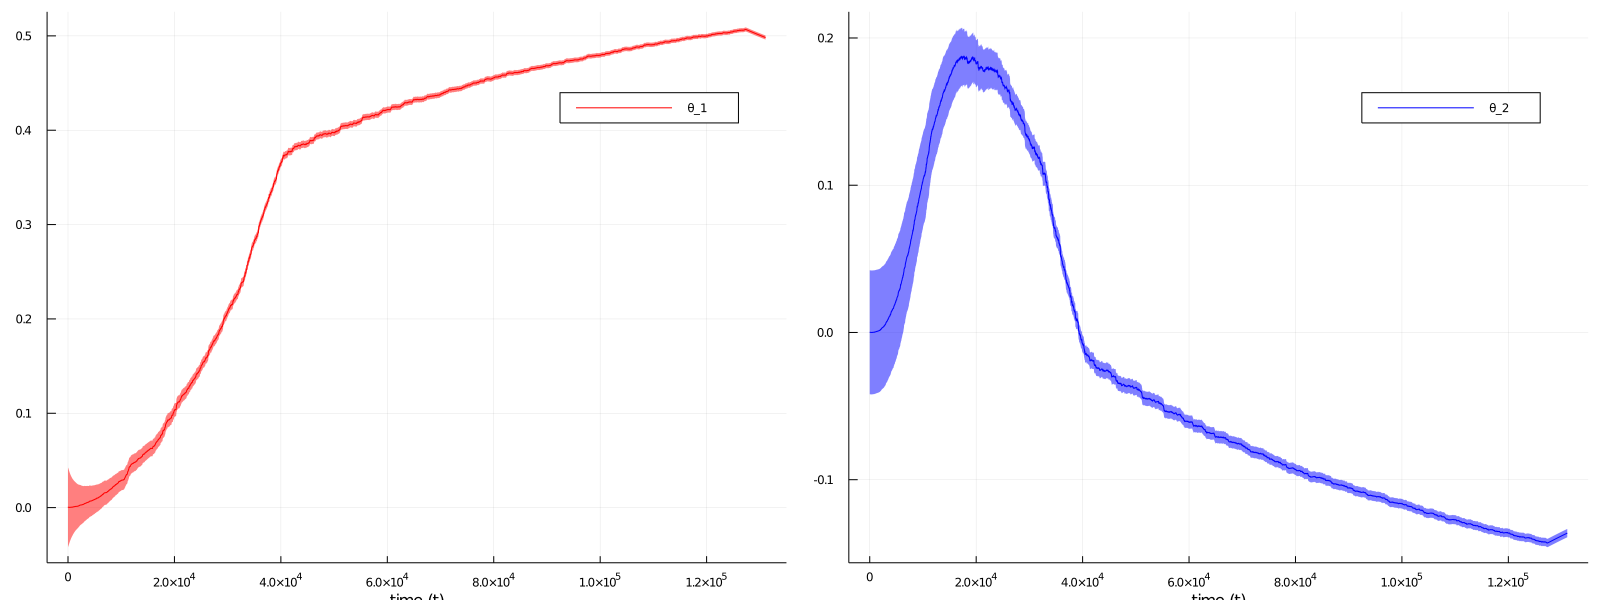

In [55]:
# Extract mean of coefficient marginals
estimated_coeffs_1_mean = params_θ[1][1,2:end]
estimated_coeffs_1_std = sqrt.(inv.(params_θ[2][1,1,2:end]))
estimated_coeffs_2_mean = params_θ[1][2,2:end]
estimated_coeffs_2_std = sqrt.(inv.(params_θ[2][2,2,2:end]))

if viz
    
#     # Plot both coefficients within the same figure
#     Plots.plot(1:n:T, estimated_coeffs_1_mean[1:n:T], ribbon=[estimated_coeffs_1_std[1:n:T], estimated_coeffs_1_std[1:n:T]], color="red", label="θ_1", xlabel="time (t)", ylim=[-1.5, 1.5])
#     Plots.plot!(1:n:T, estimated_coeffs_2_mean[1:n:T], ribbon=[estimated_coeffs_2_std[1:n:T], estimated_coeffs_2_std[1:n:T]], color="blue", label="θ_2")
# #     Plots.savefig("viz/estimated_coeffs.png")
    
    # Plot both coefficients next to each other
    p2a = Plots.plot(1:n:T, estimated_coeffs_1_mean[1:n:T], ribbon=[estimated_coeffs_1_std[1:n:T], estimated_coeffs_1_std[1:n:T]], color="red", label="θ_1", xlabel="time (t)")
    p2b = Plots.plot(1:n:T, estimated_coeffs_2_mean[1:n:T], ribbon=[estimated_coeffs_2_std[1:n:T], estimated_coeffs_2_std[1:n:T]], color="blue", label="θ_2", xlabel="time (t)")
    p2 = plot(p2a, p2b, size=(1600,600))
#     Plots.savefig(p2, "viz/estimated_coeffs_subp.png")
end

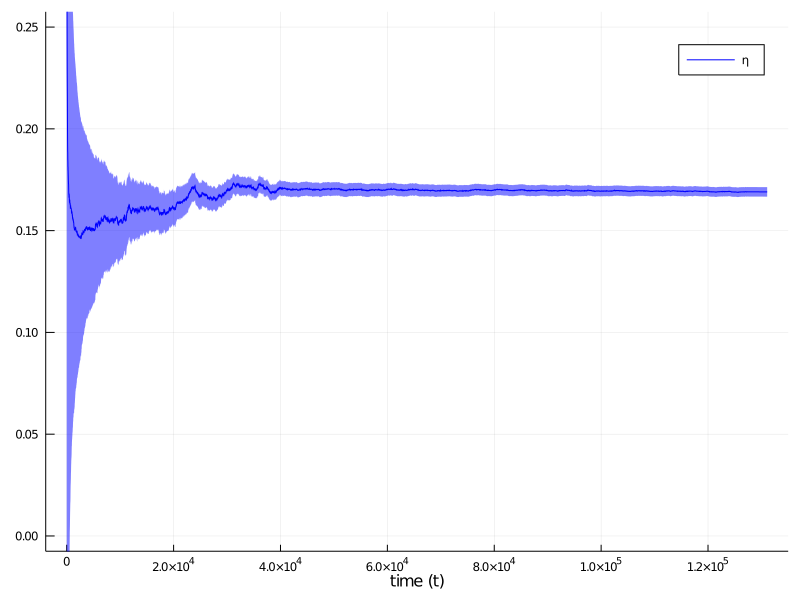

In [56]:
# Extract mean of control coefficient marginals
estimated_ccoeff_mean = params_η[1][1,2:end]
estimated_ccoeff_std = sqrt.(inv.(params_η[2][1,2:end]))

if viz
    # Plot both coefficients next to each other
    p3 = Plots.plot(1:n:T, estimated_ccoeff_mean[1:n:T], ribbon=[estimated_ccoeff_std[1:n:T], estimated_ccoeff_std[1:n:T]], color="blue", label="η", xlabel="time (t)", size=(800,600), ylim=[0.0, 0.25])
#     Plots.savefig(p3, "viz/estimated_ccoeff.png")
end

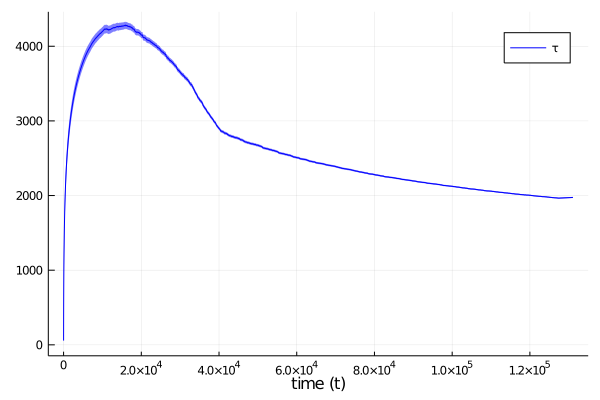

In [57]:
# Extract mean of process precision marginals
estimated_pnoise_mean = params_τ[1][1,2:end] ./ params_τ[2][1,2:end]
estimated_pnoise_std = sqrt.(params_τ[1][1,2:end] ./ params_τ[2][1,2:end].^2)

if viz
    # Plot both coefficients next to each other
    p4 = Plots.plot(1:n:T, estimated_pnoise_mean[1:n:T], ribbon=[estimated_pnoise_std[1:n:T], estimated_pnoise_std[1:n:T]],color="blue", label="τ", xlabel="time (t)")
#     Plots.savefig(p4, "viz/estimated_pnoise.png")
end

## Solving nonlinear system of equations

We currently have estimates for $\theta_1$, $\theta_2$, and $\eta$. But we want to know the original coefficients, $m$, $v$ and $a$, which actually have a physical meaning. To obtain estimates for those, we have to solve the following nonlinear system of equations:

$$\begin{align} 
\hat{\theta}_1 =&\ \frac{2m + v}{m + v + a} \\
\hat{\theta}_2 =&\ \frac{-m}{m + v + a} \\
\hat{\eta} =&\ \frac{1}{m + v + a}
\end{align}$$

Implementation using NLsolve.jl

In [58]:
using NLsolve

In [59]:
# Current estimates of parameters
global estimates = [estimated_coeffs_1_mean[end], estimated_coeffs_2_mean[end], estimated_ccoeff_mean[end]]

3-element Array{Float64,1}:
  0.4982385917012678
 -0.13626633714592234
  0.16903591726577627

In [60]:
# Define nonlinear system of equations
function F!(F, x)
    F[1] = (2*x[1] + x[2])/(x[1] + x[2] + x[3])  - estimates[1]
    F[2] = (-x[1])/(x[1] + x[2] + x[3]) - estimates[2]
    F[3] = 1/(x[1] + x[2] + x[3]) - estimates[3]
end

# Jacobian of each equation
function J!(J, x)
    
    # F[1]
    J[1, 1] = (x[2] + 2*x[3])/(x[1] + x[2] + x[3])^2
    J[1, 2] = (x[3] - x[1])/(x[1] + x[2] + x[3])^2
    J[1, 3] = (-2*x[1] - x[2])/(x[1] + x[2] + x[3])^2
    
    # F[2]
    J[2, 1] = (x[2] + x[3])/(x[1] + x[2] + x[3])^2
    J[2, 2] = x[1]/(x[1] + x[2] + x[3])^2
    J[2, 3] = x[1]/(x[1] + x[2] + x[3])^2
    
    # F[3]
    J[3, 1] = -1/(x[1] + x[2] + x[3])^2
    J[3, 2] = -1/(x[1] + x[2] + x[3])^2
    J[3, 3] = -1/(x[1] + x[2] + x[3])^2
    
end

# Call solver
x_solved = nlsolve(F!, J!, [1. 1. 1.])
# x_solved = nlsolve(f1!, [1. 1. 1.], autodiff=:forward)

# Extract new estimates
global m, v, a = x_solved.zero

1×3 Array{Float64,2}:
 1.69399  0.446801  5.38066

So, in total we estimate the dynamical parameters as follows:

In [61]:
println("m = " *string(m))
println("v = " *string(v))
println("a = " *string(a))

m = 1.6939886585526513
v = 0.44680050013586015
a = 5.3806579721056
